In [20]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from src import main, plotting, analysis, io_utils
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
df = main.main()

/data/Work/plot-tilt-stats/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Work/plot-tilt-stats/src/io_utils.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 9.92915533 15.04399737 18.9722507  ... 34.334142   34.95878496
 35.07788068]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['da']>= df['cond1'], 'gamma'] = 180*np.arccos((df.R+df.a)*(1-df.da)/df.R)/np.pi


7982
8040
8052
8056
8088
8122
8171
8404
8552
8589
8628
8649
8699
8851
8968
9063
9139
9308
9368
9396
9417
9455
9574
9660
9678
9710
9884
10130
10137
10971
10987
11007
total ARs = 108


In [4]:
DFx2=df.assign(frac=lambda x: x.alpha-x.alphab)
DFx2=DFx2.assign(t_mean=lambda x: round(10*x.t_norm)/10)

# SOME PLOTS

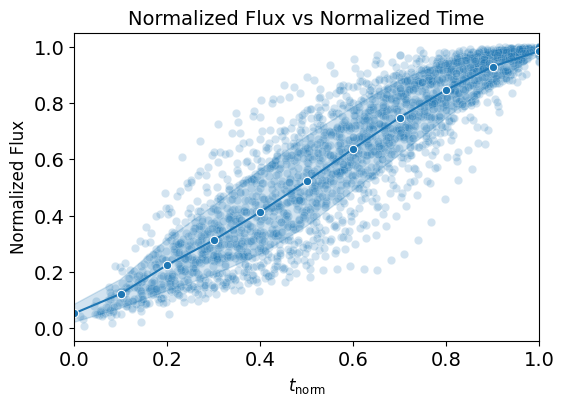

In [116]:
f,ax=plotting.plot_single(DFx2,'fint',title='Normalized Flux vs Normalized Time',scatter=True)
ax.set_ylabel('Normalized Flux')
ax.set_xlabel(r'$t_\mathrm{norm}$')
ax.set_xlim(0,1)
f.savefig('../figures/flux-all.pdf',dpi=300)

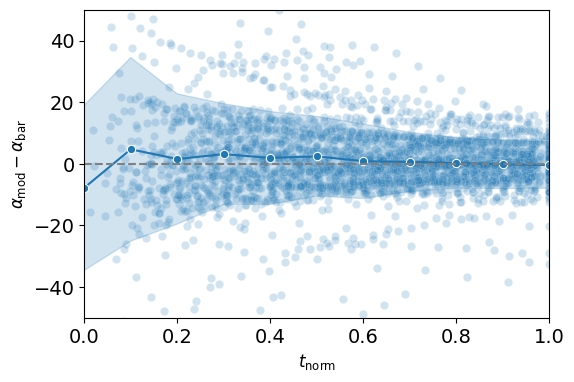

In [117]:
f,ax=plotting.plot_single(DFx2,'frac',title='',scatter=True)
ax.set_ylabel(r'$\alpha_\mathrm{mod} - \alpha_\mathrm{bar}$')
ax.set_xlabel(r'$t_\mathrm{norm}$')
ax.set_xlim(0,1)
ax.set_ylim(-50,50)
ax.axhline(0,color='gray',ls='--')
f.savefig('../figures/alpha-err.pdf',dpi=300)

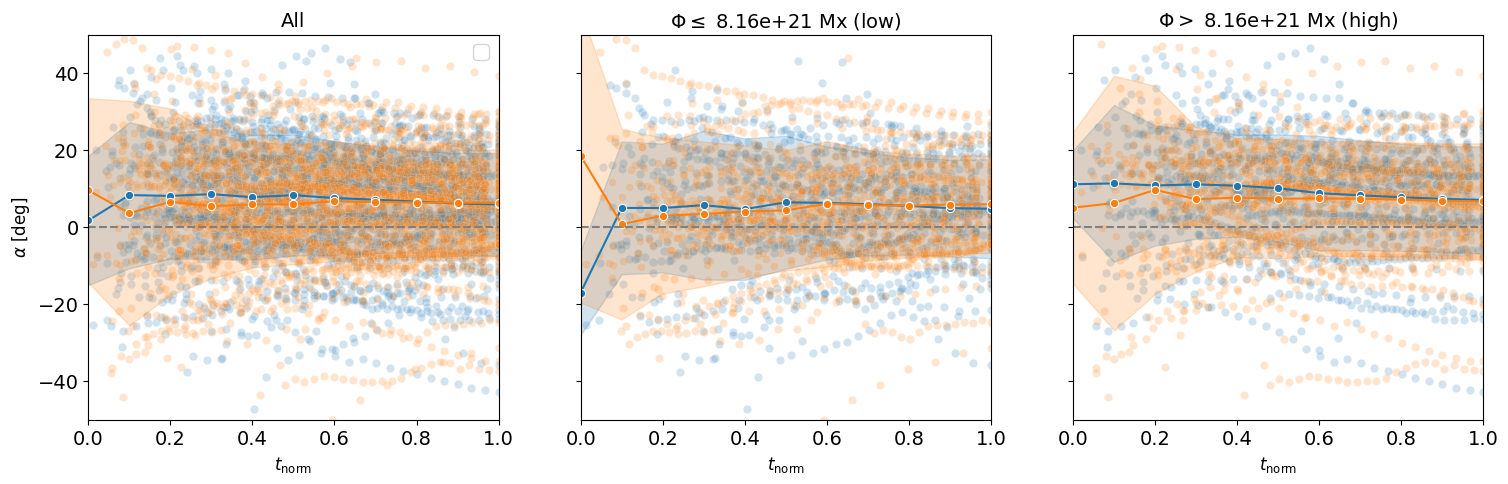

In [222]:
f,ax=plt.subplots(1,3,figsize=(18,5),sharey=True)



db=DFx2[DFx2.t_mean==1].groupby('AR').mean().reset_index()

arslowf=db[db.flux <= db.flux.median()].AR.unique()
arshighf=db[db.flux > db.flux.median()].AR.unique()


for db1,ax1,title in zip([DFx2,DFx2[DFx2.AR.isin(arslowf)],DFx2[DFx2.AR.isin(arshighf)]],ax,
                        ['All',rf'$\Phi \leq $ {db.flux.median():.2e} Mx (low)',rf'$\Phi > $ {db.flux.median():.2e} Mx (high)']):


    f,ax2=plotting.plot_single(db1,'alpha',title='',ax=ax1,fig=f,scatter=True)
    f,ax2=plotting.plot_single(db1,'alphab',title='',ax=ax1,fig=f,color='tab:orange',scatter=True)
    ax1.set_ylabel(r'$\alpha$ [deg]')
    ax1.set_xlabel(r'$t_\mathrm{norm}$')
    ax1.set_title(title)


    ax1.set_xlim(0,1)
    ax1.set_ylim(-50,50)
    ax1.axhline(0,color='gray',ls='--')

h,l=ax[0].get_legend_handles_labels()
ax[0].legend(h,l)

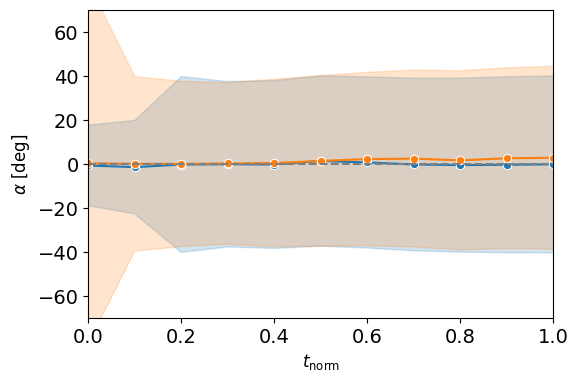

In [142]:
f,ax=plotting.plot_single(DFx2,'rot_cum',title='',estim='median')
f,ax=plotting.plot_single(DFx2,'rotb_cum',title='',ax=ax,fig=f,color='tab:orange',estim='median')
ax.set_ylabel(r'$\alpha$ [deg]')
ax.set_xlabel(r'$t_\mathrm{norm}$')
ax.set_xlim(0,1)
ax.set_ylim(-70,70)
ax.axhline(0,color='gray',ls='--')

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_169202/3431890931.py:24: SyntaxWarning: invalid escape sequence '\m'
  ax1.text(100,15,f'$\mu$: {db1.rot_cum.mean():.1f}$^\circ$\n$\sigma$: {db1.rot_cum.std():.1f}$^\circ$\nskew: {db1.rot_cum.skew():.2f}',
/tmp/ipykernel_169202/3431890931.py:24: SyntaxWarning: invalid escape sequence '\c'
  ax1.text(100,15,f'$\mu$: {db1.rot_cum.mean():.1f}$^\circ$\n$\sigma$: {db1.rot_cum

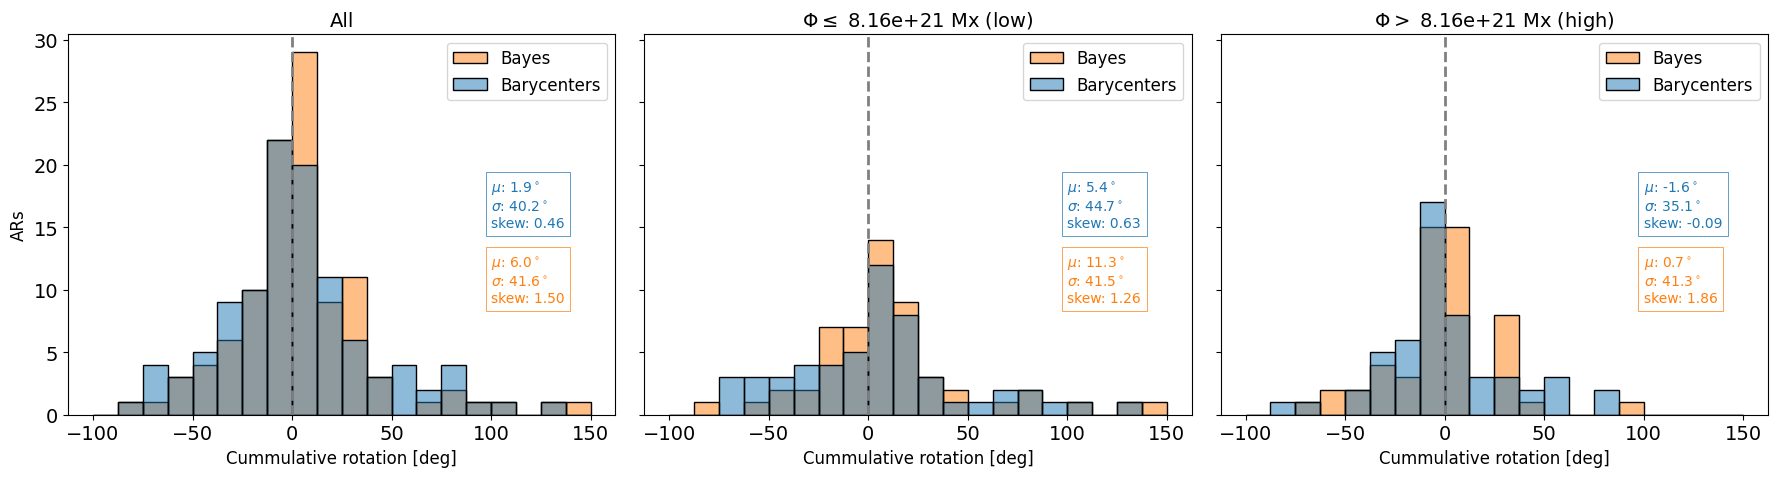

In [203]:
f,ax=plt.subplots(1,3,figsize=(18,5),sharey=True)



db=DFx2[DFx2.t_mean==1].groupby('AR').mean().reset_index()

arslowf=db[db.flux <= db.flux.median()].AR.unique()
arshighf=db[db.flux > db.flux.median()].AR.unique()


for db1,ax1,title in zip([db,db[db.AR.isin(arslowf)],db[db.AR.isin(arshighf)]],ax,
                        ['All',rf'$\Phi \leq $ {db.flux.median():.2e} Mx (low)',rf'$\Phi > $ {db.flux.median():.2e} Mx (high)']):
    sns.histplot(data=pd.melt(db1,
                            value_vars=['rot_cum','rotb_cum']),x='value',hue='variable',fill=True,ax=ax1,binrange=(-100,150),bins=20)

    ax1.set_xlabel(r'Cummulative rotation [deg]')
    ax1.set_ylabel('ARs')
    ax1.set_title(title)
    

    ax1.legend(title='',labels=['Bayes','Barycenters'],fontsize=12)
    ax1.axvline(0,color='gray',linestyle='--',linewidth=2)

    ax1.text(100,15,f'$\mu$: {db1.rot_cum.mean():.1f}$^\circ$\n$\sigma$: {db1.rot_cum.std():.1f}$^\circ$\nskew: {db1.rot_cum.skew():.2f}',
            color='tab:blue',fontsize=10,
            bbox=dict(facecolor='white', alpha=1,linewidth=0.5,edgecolor='tab:blue'))
    ax1.text(100,9,f'$\mu$: {db1.rotb_cum.mean():.1f}$^\circ$\n$\sigma$: {db1.rotb_cum.std():.1f}$^\circ$\nskew: {db1.rotb_cum.skew():.2f}',
            color='tab:orange',fontsize=10,
            bbox=dict(facecolor='white', alpha=1,linewidth=0.5,edgecolor='tab:orange'))

f.tight_layout()
f.savefig('../figures/hist_cumrot.pdf',dpi=300)

<Axes: title={'center': '$\\Phi > $ 8.16e+21'}, xlabel='Cummulative rotation [deg]', ylabel='ARs'>

(-2.0, 2.0)

(-2.0, 2.0)

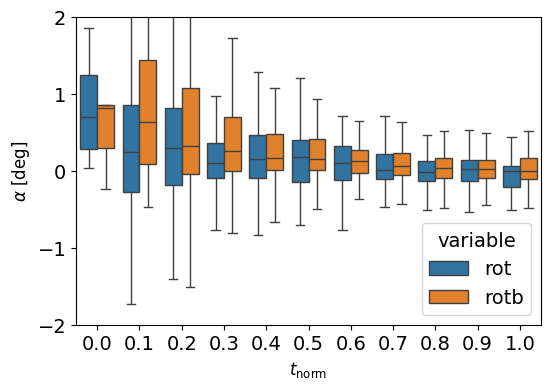

In [97]:
mdf=pd.melt(DFx2,id_vars=['t_norm','t_mean','lat','AR','mag','flux'],value_vars=['rot','rotb'])
dfm=df.groupby('AR').mean().reset_index()

mdf=mdf[(mdf.t_norm>0) & (mdf.t_norm<1.05)]

arsp1=dfm[dfm.rot_cum>0].AR.values
arsp2=dfm[dfm.rotb_cum>0].AR.values
arsn1=dfm[dfm.rot_cum<0].AR.values
arsn2=dfm[dfm.rotb_cum<0].AR.values

# crear máscaras alineadas con el DataFrame completo
mask_pos_rot  = (mdf['variable']=='rot')  & (mdf['AR'].isin(arsp1))
mask_pos_rotb = (mdf['variable']=='rotb') & (mdf['AR'].isin(arsp2))
mdf_pos = mdf[mask_pos_rot | mask_pos_rotb]

mask_neg_rot  = (mdf['variable']=='rot')  & (mdf['AR'].isin(arsn1))
mask_neg_rotb = (mdf['variable']=='rotb') & (mdf['AR'].isin(arsn2))
mdf_neg = mdf[mask_neg_rot | mask_neg_rotb]

f,ax=plt.subplots()
#sns.lineplot(data=mdf,x='t_mean',y='value',estimator='mean',hue='variable',marker='o',errorbar='sd',err_style='bars')
sns.boxplot(data=mdf_pos,x='t_mean',y='value',hue='variable',ax=ax,fliersize=False)
#sns.boxplot(data=mdf_neg,x='t_mean',y='value',hue='variable',ax=ax,fliersize=False)
ax.set_ylabel(r'$\alpha$ [deg]')
ax.set_xlabel(r'$t_\mathrm{norm}$')
ax.set_ylim(-2,2)

In [90]:
mdf_neg

,t_norm,t_mean,lat,AR,mag,flux,variable,value
0,0.062133,0.1,-22,8193,0.0,5.281523e+20,rot,-0.466656
1,0.124657,0.1,-22,8193,4.0,7.043322e+20,rot,-2.379739
2,0.187182,0.2,-22,8193,8.0,1.134488e+21,rot,-2.700517
3,0.249706,0.2,-22,8193,12.0,1.505539e+21,rot,-0.653158
4,0.312231,0.3,-22,8193,16.0,2.057652e+21,rot,-0.149742
...,...,...,...,...,...,...,...,...
5699,0.820466,0.8,-7,10747,45.0,4.781975e+21,rotb,-0.014032
5700,0.865349,0.9,-7,10747,48.0,5.608403e+21,rotb,-0.065235
5701,0.910233,0.9,-7,10747,51.0,6.291583e+21,rotb,0.025737
5702,0.955116,1.0,-7,10747,54.0,7.145513e+21,rotb,0.218069


In [59]:
mdf[mdf[mdf.variable=='rot'].AR.isin(arsp1) | mdf[mdf.variable=='rotb'].AR.isin(arsp2)]

,t_norm,t_mean,lat,AR,mag,flux,variable,value
55,0.110141,0.1,21,8205,0.0,8.337108e+20,rot,1.016246
56,0.165757,0.2,21,8205,3.0,9.320127e+20,rot,0.747747
57,0.221373,0.2,21,8205,6.0,1.380207e+21,rot,0.302321
58,0.276989,0.3,21,8205,9.0,1.802994e+21,rot,0.076882
59,0.332606,0.3,21,8205,12.0,2.700225e+21,rot,-0.014820
...,...,...,...,...,...,...,...,...
2847,0.820466,0.8,-7,10747,45.0,4.781975e+21,rot,-0.076351
2848,0.865349,0.9,-7,10747,48.0,5.608403e+21,rot,-0.625460
2849,0.910233,0.9,-7,10747,51.0,6.291583e+21,rot,-0.506897
2850,0.955116,1.0,-7,10747,54.0,7.145513e+21,rot,0.538834


TypeError: unsupported operand type(s) for /: 'range' and 'int'

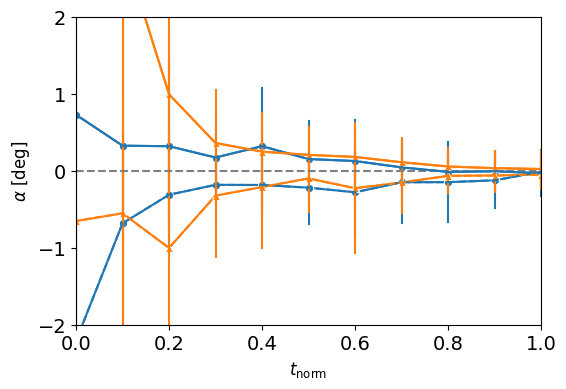

In [17]:
dfm=df.groupby('AR').mean().reset_index()

arsp=dfm[dfm.rot_cum>0].AR.values
arsn=dfm[dfm.rot_cum<0].AR.values

# plot rot_cum in blue with circle marker and solid line
f,ax=plotting.plot_single(DFx2[DFx2.AR.isin(arsp)],'rot',title='',marker='o',color='tab:blue',error='bars',err_kws={'alpha':1})
line1 = ax.lines[-1]
line1.set_linestyle('-')  # línea sólida para rot_cum

# plot rot_cum in blue with circle marker and solid line
f,ax=plotting.plot_single(DFx2[DFx2.AR.isin(arsn)],'rot',title='',marker='o',color='tab:blue',error='bars',err_kws={'alpha':1},ax=ax,fig=f)
line1 = ax.lines[-1]
line1.set_linestyle('--')  # línea sólida para rot_cum

arsp=dfm[dfm.rotb_cum>0].AR.values
arsn=dfm[dfm.rotb_cum<0].AR.values

# plot rotb_cum in orange with triangle marker and dashed line
f,ax=plotting.plot_single(DFx2[DFx2.AR.isin(arsp)],'rotb',title='',ax=ax,fig=f,marker='^',color='tab:orange',error='bars',err_kws={'alpha':1})
line2 = ax.lines[-1]
line2.set_linestyle('-')  # línea punteada para rotb_cum

f,ax=plotting.plot_single(DFx2[DFx2.AR.isin(arsn)],'rotb',title='',ax=ax,fig=f,marker='^',color='tab:orange',error='bars',err_kws={'alpha':1})
line2 = ax.lines[-1]
line2.set_linestyle('--')  # línea punteada para rotb_cum

ax.set_ylabel(r'$\alpha$ [deg]')
ax.set_xlabel(r'$t_\mathrm{norm}$')
ax.set_xlim(0,1)
ax.set_ylim(-2,2)
ax.axhline(0,color='gray',ls='--')

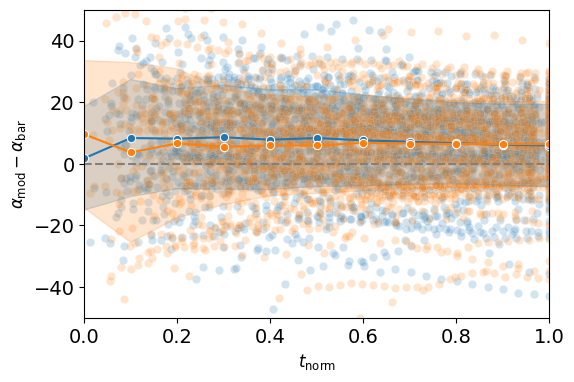

In [ ]:
f,ax=plotting.plot_comparison(DFx2,'alpha','alphab',title='',all=True)
ax.set_ylabel(r'$\alpha_\mathrm{mod} - \alpha_\mathrm{bar}$')
ax.set_xlabel(r'$t_\mathrm{norm}$')
ax.set_xlim(0,1)
ax.set_ylim(-50,50)
ax.axhline(0,color='gray',ls='--')

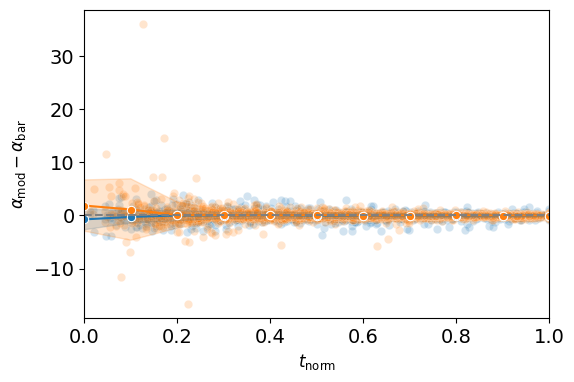

In [ ]:
f,ax=plotting.plot_comparison(DFx2,'rot','rotb',title='',all=True)
ax.set_ylabel(r'$\alpha_\mathrm{mod} - \alpha_\mathrm{bar}$')
ax.set_xlabel(r'$t_\mathrm{norm}$')
ax.set_xlim(0,1)
#ax.set_ylim(-50,50)
ax.axhline(0,color='gray',ls='--')